In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

from diffusion.sampler import *
from diffusion.utils import plot_images
from diffusion.datasets import cifar10_labels

device = "cuda:1" # Change this to which device you want to run on

/home/heng/micromamba/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Naive model

In [2]:
# Get model and encoder
from diffusion.train_scripts.cifar10_naive import get_models as get_naive_models
naive_model = get_naive_models(device)

# Load in the trained weights
naive_model.load_state_dict(torch.load('final_models/cifar10_naive_ema.pth'))

# Create sampler
naive_sampler = Sampler(
    model=naive_model,
    label_list=cifar10_labels, # Used to lookup label names when you sample using text (as we don't have an encoder)
    device=device
)

ModuleNotFoundError: No module named 'cifar10_naive'

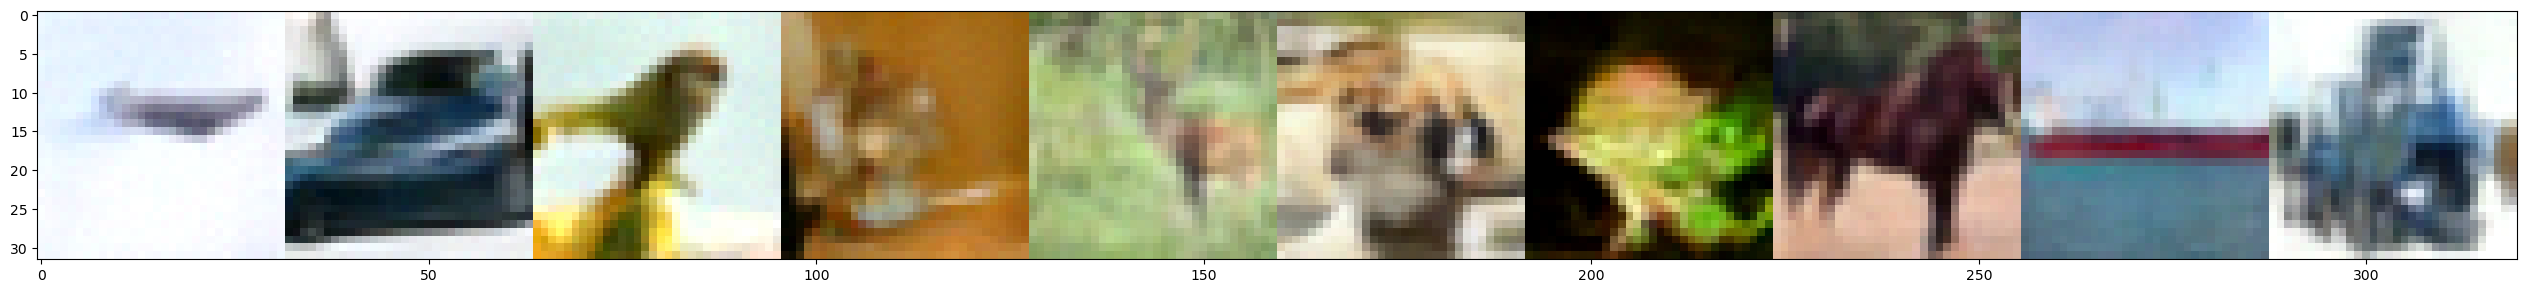

In [3]:
plot_images(naive_sampler.sample_list_of_text(cifar10_labels))

# Text model

In [4]:
# Get model and encoder
from cifar10_text import get_models as get_clip_models
text_model, text_embedding_model, _ = get_clip_models(device)

# Load in the trained weights
text_model.load_state_dict(torch.load('final_models/cifar10_text_ema.pth'))

# Create sampler
text_sampler = Sampler(
    model=text_model,
    text_embedder=text_embedding_model.encode,
    device=device
)

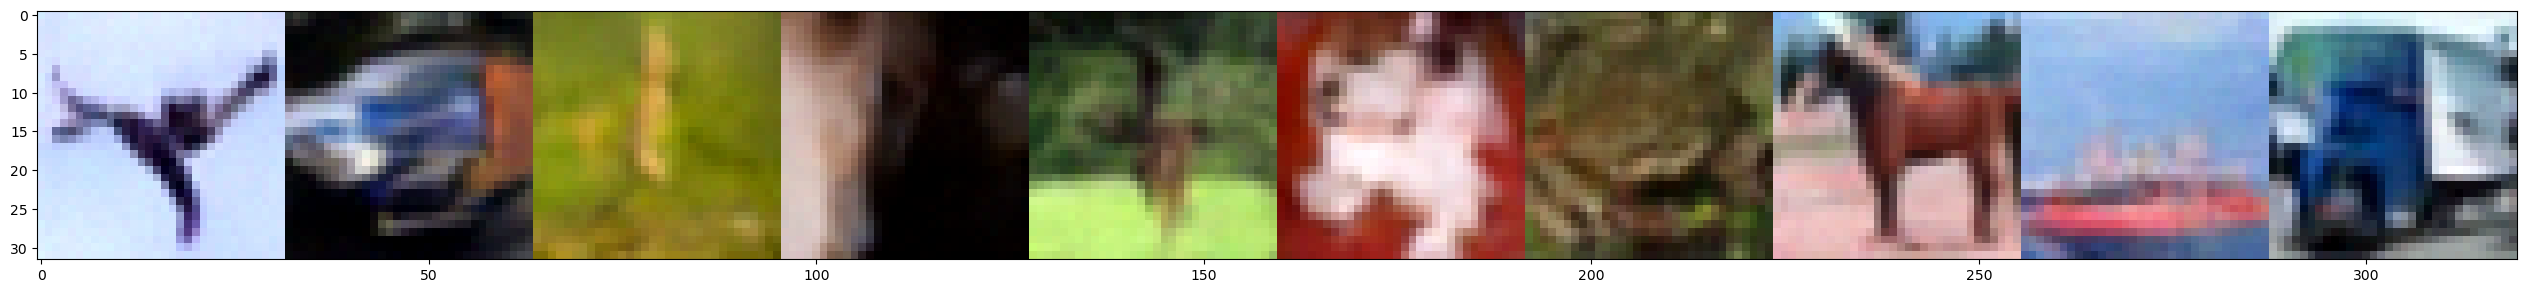

In [5]:
plot_images(text_sampler.sample_list_of_text(cifar10_labels))

# CLIP model

In [6]:
# Get model and encoder
from cifar10_clip import get_models as get_clip_models
clip_model, clip_embedding_model, _ = get_clip_models(device)

# Load in the trained weights
clip_model.load_state_dict(torch.load('final_models/cifar10_clip_ema.pth'))

# Create sampler
clip_sampler = Sampler(
    model=clip_model,
    text_embedder=clip_embedding_model.encode,
    device=device
)

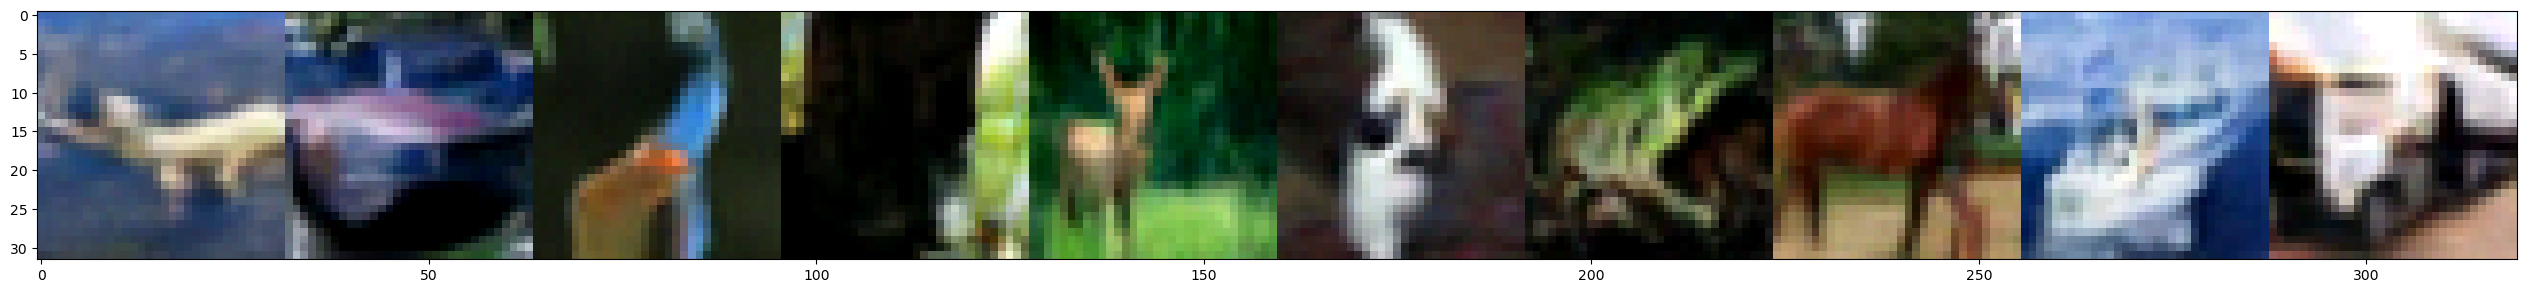

In [7]:
plot_images(clip_sampler.sample_list_of_text(cifar10_labels))

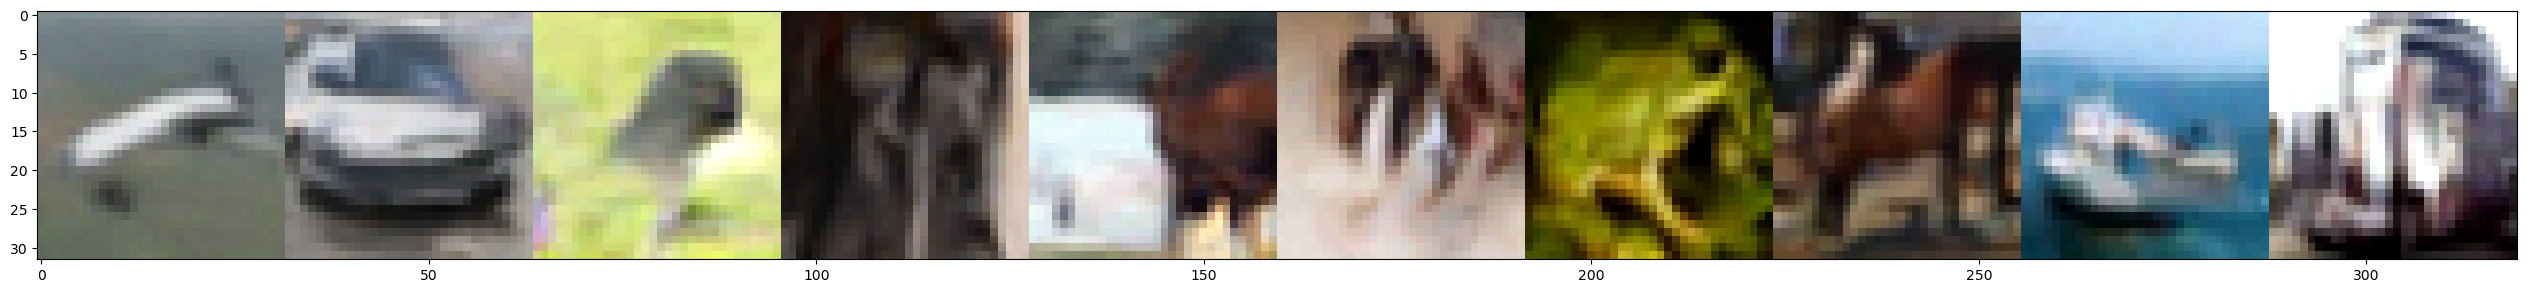

In [8]:
# Convert the cifar labels into centenses for the sentence encoder CLIP
cifar10_sentences = [f"This is a picture of a {label}" for label in cifar10_labels]
plot_images(clip_sampler.sample_list_of_text(cifar10_sentences))

In [12]:
'''
\begin{algorithm}[ht]
\begin{algorithmic}
   \STATE {\bfseries Input:} datasets $D$, models $M$, number of labels $n$
   \STATE {\bfseries Output:} Cosine similarity scores for each model
   
   \FORALL{dataset $d$ in $D$}
   \FORALL{data point in $d$}
   \STATE Select $n$ random labels $L$ from $d$
   \STATE Generate combined label context $C_{lc}$ from $L$
   \FORALL{model $m$ in $M$}
   \STATE Initialize scores list $S_m$ for model $m$
   \IF{$m$ is CLIP}
   \STATE Use $C_{lc}$ directly for generating image $I$
   \ELSIF{$m$ is Text Embedding}
   \STATE Sum embeddings of each label in $L$ to get $C_{te}$
   \STATE Use $C_{te}$ for generating image $I$
   \ELSE
   \STATE Average embeddings of $L$ to get $C_{naive}$
   \STATE Use $C_{naive}$ for generating image $I$
   \ENDIF
   \STATE Encode $I$ using CLIP to get vector $V_I$
   \STATE Calculate cosine similarity $score$ between $V_I$ and the CLIP embedding of $C_{lc}$
   \STATE Append $score$ to $S_m$
   \ENDFOR
   \ENDFOR
   \ENDFOR
   \STATE \textbf{return} $S_m$ for each model $m$
\end{algorithmic}
\caption{Direct Comparison of Image Generation Models}
\label{alg:direct_comp_img_gen_models}
\end{algorithm}
'''

import random

def labels_to_sentence(labels):
    '''
    Given a list of labels make a sentence: This is a picture of label1, label2, label3, ... combined
    '''
    return f"This is a picture of {' '.join(labels)} combined"


def clip_similarity_score(image, label_context, clip_sampler):
    '''
    Given an image and a label context, calculate the cosine similarity between the image and the label context
    '''
    image_embedding = clip_sampler.encode(image)
    label_context_embedding = clip_sampler.encode(label_context)
    return torch.nn.functional.cosine_similarity(image_embedding, label_context_embedding)

def naive_embedding_combiner(labels, naive_sampler):
    '''
    Given a list of labels, combine the embeddings of each label into a single embedding
    '''
    label_embeddings = [naive_sampler.encode(label) for label in labels]
    return torch.stack(label_embeddings).mean(dim=0)

def text_embedding_combiner(labels, text_sampler):
    '''
    Given a list of labels, add the embeddings together
    '''
    label_embeddings = [text_sampler.encode(label) for label in labels]
    return torch.stack(label_embeddings).sum(dim=0)

def direct_comparison_of_image_generation_models(datasets, models, n):
    '''
    Direct comparison of image generation models
    '''
    for dataset in datasets:
        for data_point in dataset:
            random_n_labels = random.sample(dataset, n)
            label_context = labels_to_sentence(random_n_labels)
            for model in models:
                scores = []
                if model == 'clip':
                    image = clip_sampler.sample_list_of_text([label_context])
                    score = clip_similarity_score(image, label_context, clip_sampler)
                    scores.append(score)
                elif model == 'text_embedding':
                    label_context_embedding = text_embedding_combiner(random_n_labels, text_sampler)
                    image = text_sampler.sample(label_context_embedding)
                    score = clip_similarity_score(image, label_context, clip_sampler)
                    scores.append(score)
                else:
                    label_context_embedding = naive_embedding_combiner(random_n_labels, naive_sampler)
                    image = naive_sampler.sample(label_context_embedding)
                    score = clip_similarity_score(image, label_context, clip_sampler)
                    scores.append(score)
    return scores

# Direct comparison of image generation models
datasets = [cifar10_labels]
models = ['naive', 'text_embedding', 'clip']
n = 3
scores = direct_comparison_of_image_generation_models(datasets, models, n)
print(scores)

This is a picture of frog airplane cat


AttributeError: 'Sampler' object has no attribute 'encode'